In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd 'drive/My Drive'

/content/drive/My Drive


In [ ]:
# IMPORTAMOS las librerias necesarias
import numpy as np
from keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, Reshape, LeakyReLU, MaxPooling2D, UpSampling2D, Lambda
from keras.models import Model
from keras.layers.merge import concatenate
from keras.regularizers import l2
from keras import backend as K
from keras.models import load_model
import tensorflow as tf


In [ ]:
# Ruta del archivo de pesos
weight_p = 'Vision_YOLO/yolov3-tiny.weights' 

# Cargar pesos y configuracion
weights_file = open(weight_p, 'rb')  # abrir para lectura (r) y en modo binario (b)

weights_header = np.ndarray(shape=(5, ), dtype='int32', buffer=weights_file.read(20))

In [ ]:
# Funcion para establecer los pesos
# Darknet serializa los pesos convolucionales como:
#[bias/beta, [gamma, mean, variance], conv_weights]
def set_weights(filters ,size, input, weights_file, flag_batch):
  prev_layer_shape = K.int_shape(input)

  weights_shape = (size, size, prev_layer_shape[-1], filters)
  darknet_w_shape = (filters, weights_shape[2], size, size)
  weights_size = np.product(weights_shape)

  conv_bias = np.ndarray(
    shape=(filters, ),
    dtype='float32',
    buffer=weights_file.read(filters * 4))
  

  conv_weights = []
  bn_weight_list = []

# Aplicamos batch normalization si el flag es True
  if flag_batch:
    bn_weights = np.ndarray(
        shape=(3, filters),
        dtype='float32',
        buffer=weights_file.read(filters * 12))

    # TODO: Keras BatchNormalization mistakenly refers to var
    # as std.
    bn_weight_list = [
        bn_weights[0],  # scale gamma
        conv_bias,  # shift beta
        bn_weights[1],  # running mean
        bn_weights[2]  # running var
    ]

  conv_weights = np.ndarray(
      shape=darknet_w_shape,
      dtype='float32',
      buffer=weights_file.read(weights_size * 4))

  # DarkNet conv_weights are serialized Caffe-style:
  # (out_dim, in_dim, height, width)
  # We would like to set these to Tensorflow order:
  # (height, width, in_dim, out_dim)
  # TODO: Add check for Theano dim ordering.
  conv_weights = np.transpose(conv_weights, [2, 3, 1, 0])

  conv_weights = [conv_weights] if flag_batch else [conv_weights, conv_bias]

  return conv_weights, bn_weight_list

  # https://github.com/xiaochus/YOLOv3/blob/master/yad2k.py

In [ ]:
Input_Tensor = Input(shape=(416, 416, 3), name='Input')  #Tensor para el tamaño de entrada de la primera capa 416 x 416 x 3
regulador = 0.01

# ******** set_weights *************
conv_weights, bn_weight_list = set_weights(16, 3, Input_Tensor ,weights_file , True)

# Layer 0
x = Conv2D(16, (3,3), strides=(1,1), kernel_regularizer=l2(regulador), weights=conv_weights, padding='same', name='conv_0', use_bias=False)(Input_Tensor)

x = BatchNormalization(weights=bn_weight_list, name='norm_0')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 1
x = MaxPooling2D(pool_size=(2, 2), name='Max_1')(x)

# ******** set_weights *************
conv_weights, bn_weight_list = set_weights(32 ,3  ,x ,weights_file , True)

# Layer 2
x = Conv2D(32, (3,3), strides=(1,1), kernel_regularizer=l2(regulador), weights=conv_weights, padding='same', name='conv_2', use_bias=False)(x)
x = BatchNormalization(weights=bn_weight_list, name='norm_2')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 3
x = MaxPooling2D(pool_size=(2, 2), name='Max_3')(x)

# ******** set_weights *************
conv_weights, bn_weight_list = set_weights(64 ,3, x,weights_file , True)

# Layer 4
x = Conv2D(64, (3,3), strides=(1,1), kernel_regularizer=l2(regulador), weights=conv_weights, padding='same', name='conv_4', use_bias=False)(x)
x = BatchNormalization(weights=bn_weight_list, name='norm_4')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 5
x = MaxPooling2D(pool_size=(2, 2),name = 'Max_5')(x)

# ******** set_weights *************
conv_weights, bn_weight_list= set_weights(128 ,3, x,weights_file , True)

# Layer 6
x = Conv2D(128, (3,3), strides=(1,1), kernel_regularizer=l2(regulador), weights=conv_weights, padding='same', name='conv_6', use_bias=False)(x)
x = BatchNormalization(weights=bn_weight_list, name='norm_6')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 7
x = MaxPooling2D(pool_size=(2, 2), name='Max_7')(x)

# ******** set_weights *************
conv_weights, bn_weight_list = set_weights(256 ,3 ,x ,weights_file , True)

# Layer 8
x = Conv2D(256, (3,3), strides=(1,1), kernel_regularizer=l2(regulador), weights=conv_weights, padding='same', name='conv_8', use_bias=False)(x)
x = BatchNormalization(weights=bn_weight_list, name='norm_8')(x)
x = LeakyReLU(alpha=0.1)(x)

route20 = x  # route layer 20

# Layer 9
x = MaxPooling2D(pool_size=(2, 2), name = 'Max_9')(x)

# ******** set_weights *************
conv_weights, bn_weight_list= set_weights(512 ,3,x ,weights_file , True)

# Layer 10
x = Conv2D(512, (3,3), strides=(1,1), kernel_regularizer=l2(regulador), weights=conv_weights, padding='same', name='conv_10', use_bias=False)(x)
x = BatchNormalization(weights=bn_weight_list, name='norm_10')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 11
x = MaxPooling2D(padding='same', pool_size=(2, 2), strides=(1,1), name='Max_11')(x)

# ******** set_weights *************
conv_weights, bn_weight_list = set_weights(1024 ,3, x ,weights_file , True)

# Layer 12
x = Conv2D(1024, (3,3), strides=(1,1), kernel_regularizer=l2(regulador), weights=conv_weights, padding='same', name='conv_12', use_bias=False)(x)
x = BatchNormalization(weights=bn_weight_list, name='norm_12')(x)
x = LeakyReLU(alpha=0.1)(x)

# ******** set_weights *************
conv_weights, bn_weight_list = set_weights(256 ,1, x ,weights_file , True)

# Layer 13
x = Conv2D(256, (1,1), strides=(1,1), kernel_regularizer=l2(regulador), weights=conv_weights, padding='same', name='conv_13', use_bias=False)(x)
x = BatchNormalization(weights=bn_weight_list, name='norm_13')(x)
x = LeakyReLU(alpha=0.1)(x)

route17 = x # Route layer 17

# ******** set_weights *************
conv_weights, bn_weight_list = set_weights(512 ,3, x ,weights_file , True)

# Layer 14
x = Conv2D(512, (3,3), strides=(1,1), kernel_regularizer=l2(regulador), weights=conv_weights, padding='same', name='conv_14', use_bias=False)(x)
x = BatchNormalization(weights=bn_weight_list, name='norm_14')(x)
x = LeakyReLU(alpha=0.1)(x)

# ******** set_weights *************
conv_weights, bn_weight_list = set_weights(255 ,1 ,x ,weights_file , False)

# Layer 15
x = Conv2D(255, (1,1), strides=(1,1), kernel_regularizer=l2(regulador), weights=conv_weights, padding='same',name='conv_15', use_bias=True)(x)

# Layer 16 - yolo
yolo0 = Reshape((13, 13, 3, 85))(x)

# Layer 17 - route
# ******** set_weights *************
conv_weights, bn_weight_list= set_weights(128 ,1 ,route17 ,weights_file , True)

# Layer 18 - route layer
x = Conv2D(128, (1,1), strides=(1,1), kernel_regularizer=l2(regulador), weights=conv_weights, padding='same', name='conv_18', use_bias=False)(route17)
x = BatchNormalization(weights=bn_weight_list, name='norm_18')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 19 - upsample
x = UpSampling2D(size=(2, 2), name='UpS_19')(x)

# Layer 20 - route
# Obtener el Input para la siguiente capa de convolucion, fusion de la capa 19 y la 8
x = concatenate([route20, x])

# ******** set_weights *************
conv_weights, bn_weight_list = set_weights(256 ,3 ,x ,weights_file , True)

# Layer 21
x = Conv2D(256, (3,3), strides=(1,1), kernel_regularizer=l2(regulador), weights=conv_weights, padding='same', name='conv_21', use_bias=False)(x)
x = BatchNormalization(weights=bn_weight_list, name='norm_21')(x)
x = LeakyReLU(alpha=0.1)(x)

# ******** set_weights *************
conv_weights, bn_weight_list = set_weights(255 ,1 ,x ,weights_file , False)

# Layer 22
x = Conv2D(255, (1,1), strides=(1,1), kernel_regularizer=l2(regulador), weights=conv_weights, padding='same', name='conv_22', use_bias=True)(x)

# Layer 23 - yolo
yolo1 = Reshape((26, 26, 3, 85))(x)

# Create and save model.
model = Model(inputs=[Input_Tensor],  outputs=[yolo0, yolo1])

#Compilar el modelo
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# Salvar el modelo como .h5
model.save('{}'.format('model_yolo.h5'))

In [ ]:
#MOSTRAR UN RESUMEN DEL MODELO
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 416, 416, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_0 (Conv2D)                (None, 416, 416, 16  432         ['Input[0][0]']                  
                                )                                                                 
                                                                                                  
 norm_0 (BatchNormalization)    (None, 416, 416, 16  64          ['conv_0[0][0]']                 
                                )                                                             

Objetos encontrados: 
  sofa 81.35508298873901
  silla 27.66617238521576


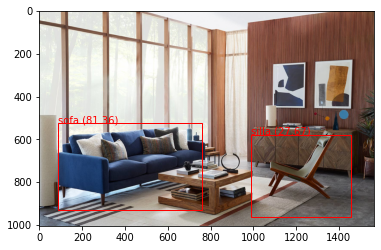

In [ ]:
# Segunda version para interpretar 
import numpy as np
from numpy import expand_dims
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from matplotlib import pyplot
from matplotlib.patches import Rectangle

class BoundBox:
	def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
		self.xmin = xmin
		self.ymin = ymin
		self.xmax = xmax
		self.ymax = ymax
		self.objness = objness
		self.classes = classes
		self.label = -1
		self.score = -1

	def get_label(self):
		if self.label == -1:
			self.label = np.argmax(self.classes)

		return self.label

	def get_score(self):
		if self.score == -1:
			self.score = self.classes[self.get_label()]

		return self.score

def _sigmoid(x):
	return 1. / (1. + np.exp(-x))
 
def decode_netout(netout, anchors, threshold_objsh, net_h, net_w):
	grid_h, grid_w = netout.shape[:2]
	nb_box = 3
	netout = netout.reshape((grid_h, grid_w, nb_box, -1))
	nb_class = netout.shape[-1] - 5
	boxes = []
	netout[..., :2]  = _sigmoid(netout[..., :2])
	netout[..., 4:]  = _sigmoid(netout[..., 4:])
	netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
	netout[..., 5:] *= netout[..., 5:] > threshold_objsh

	for i in range(grid_h*grid_w):
		row = i / grid_w
		col = i % grid_w
		for b in range(nb_box):
			# 4 elemento es la puntuación de objeto 
			objectness = netout[int(row)][int(col)][b][4]
			if(objectness.all() <= threshold_objsh): continue
			# 4 primeros elementos: x, y, w, and h
			x, y, w, h = netout[int(row)][int(col)][b][:4]
			# posicion centro (ancho y alto)
			x = (col + x) / grid_w 
			y = (row + y) / grid_h 
			w = anchors[2 * b + 0] * np.exp(w) / net_w 
			h = anchors[2 * b + 1] * np.exp(h) / net_h 
			# ultimo elemento = probailidad de clase
			classes = netout[int(row)][col][b][5:]
			box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
			boxes.append(box)
	return boxes

def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
	new_w, new_h = net_w, net_h
	for i in range(len(boxes)):
		x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
		y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
		boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
		boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
		boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
		boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

def _interval_overlap(interval_a, interval_b):
	x1, x2 = interval_a
	x3, x4 = interval_b
	if x3 < x1:
		if x4 < x1:	# no hay interseccion
			return 0
		else:
			return min(x2,x4) - x1
	else:
		if x2 < x3:	# no hay interseccion
			 return 0
		else:
			return min(x2,x4) - x3

def bbox_iou(box1, box2):
	intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
	intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
 
	intersect_area = intersect_w * intersect_h

	w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
	w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin

	union = w1*h1 + w2*h2 - intersect_area
	
	return float(intersect_area) / union

def supress_nms(boxes, nms_thresh):
	if len(boxes) > 0:
		nb_class = len(boxes[0].classes)
	else:
		return

	for c in range(nb_class):
		sorted_indices = np.argsort([-box.classes[c] for box in boxes])
		for i in range(len(sorted_indices)):
			index_i = sorted_indices[i]
			if boxes[index_i].classes[c] == 0: continue
			for j in range(i+1, len(sorted_indices)):
				index_j = sorted_indices[j]
				if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
					boxes[index_j].classes[c] = 0

def load_Image(filename, shape):
    # Cargamos la imagen y salvamos su tamaño
    image = load_img(filename)
    width, height = image.size

    # Cargar la imagen con el tamaño adecuado
    image = load_img(filename, target_size=shape)

    # Convertimos a un numpy array 
    image = img_to_array(image)

    # normzalizamos: valores entre [0, 1] acelerar proceso de computo
    image = image.astype('float32')
    image /= 255.0

    # añadimos una dimensión para tener una muestra
    image = expand_dims(image, 0)
    return image, width, height


# Obtine los resultados que esten por encima del umbral
def get_boxes(boxes, labels, thresh):
	v_boxes, v_labels, v_scores = list(), list(), list()
 
	# Recorremos todas las cajas y todas las etiquetas posibles
	for box in boxes:
		for i in range(len(labels)):
			# puntuacion supera el umbral?
			if box.classes[i] > thresh:
				v_boxes.append(box)
				v_labels.append(labels[i])
				v_scores.append(box.classes[i]*100)
		
	return v_boxes, v_labels, v_scores

# Dibujar las cajas
def draw_boxes(filename, v_boxes, v_labels, v_scores):
	# cargamos la imagen
	data = pyplot.imread(filename)
	pyplot.imshow(data)
	# obtner el contexto
	ax = pyplot.gca()
	
	for i in range(len(v_boxes)):
		box = v_boxes[i]
		# obtiene coordenadas
		y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
		# Calculo del ancho y alto de la caja
		width, height = x2 - x1, y2 - y1
		# Dibujar cuadro
		rect = Rectangle((x1, y1), width, height, fill=False, color='red')
		ax.add_patch(rect)
		# Escribir texto y puntuación
		label = "%s (%.2f)" % (v_labels[i], v_scores[i])
		pyplot.text(x1, y1, label, color='red' )
	pyplot.show()
 
# Cargamos el modelo
yolo = load_model('model_yolo.h5')
# Tamaño esperado para el modelo
input_h, input_w = 416, 416
# Path de la imagen
input_image_name = 'Vision_YOLO/sofa.jpeg'
# Cargar y preparar la imagen
image, image_w, image_h = load_Image(input_image_name, (input_w, input_h))
# hacemos la prediccion
output = yolo.predict(image)

# Definición de las anclas
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]

class_threshold = 0.27	#umbral para los objetos detectados
boxes = list()

for i in range(len(output)):
	# Decodificar la salida
	boxes += decode_netout(output[i][0], anchors[i], class_threshold, input_h, input_w)
# Adaptar los tamaños de los cuadros delimitadores al tamaño original
correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)
# supresion de non-maximal boxes 
supress_nms(boxes, 0.6)

# Conjunto de equiteas - valores 
labels = ["persona", "bicicleta", "coche", "moto", "avión", "bus", "tren", "camión", "barco", "semáforo", "boca de incendio", "señal de stop", "parquimetro", "banco",
	"pajaro", "gato", "perro", "caballo", "oveja", "vaca", "elefante", "oso", "cebra", "jirafa", "mochila", "paraguas", "bolso", "corbata", "maleta", "frisbee", "esquis", "snowboard",
	"deporte de balon", "cometa", "bate besibol", "guante beisbol", "skateboard", "tabla de surf", "raqueta", "botella", "copa", "taza", "tenedor", "cuchillo", "cuchara", "bowl", 
	"banana", "manzana", "sandwich", "naranja", "broccoli", "zanahoria", "hot-dog", "pizza", "donut", "tarta", "silla", "sofa", "maceta", "cama", "mesa", "inodoro", "tvmonitor", 
	"portatil", "raton", "remoto", "teclado", "movil", "microondas", "horno", "tostadora", "lavabo", "frigorifico", "libro", "reloj", "jarron", "tijeras", "oso peluche", "secador", 
	"cepillo dental"]

# Obtencion de detalles para los objetos detectados
v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)

# Resumen de lo encontrado
print('Objetos encontrados: ')
for i in range(len(v_boxes)):
	print(' ', v_labels[i], v_scores[i])

draw_boxes(input_image_name, v_boxes, v_labels, v_scores)